In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)



    
    
    for file_path in json_files:
  
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue

            # Skip results with specific model types
            excluded_models = ["gaussian_sharedPrior", "fusionOnly_sharedPrior", "probabilityMatching_sharedPrior", "switching_sharedPrior"]
            if any(model in result['modelType'] for model in excluded_models):
                # Skip this result
                os.remove(file_path)
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}\n number of models in comparison is: {len(df_results['modelType'].unique())} ")


Loaded 78 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']
 number of models in comparison is: 6 


In [3]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions
0,sx,switchingFree_sharedPrior,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548
1,sx,lognorm_sharedPrior,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548
2,sx,logLinearMismatch_sharedPrior,"[0.05612607853226369, 0.2885361430902179, 0.27...",2168.476558,2198.620485,-1077.238279,548
3,sx,fusionOnlyLogNorm_sharedPrior,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548
4,sx,selection_sharedPrior,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548
...,...,...,...,...,...,...,...
73,ip,selection_sharedPrior,"[0.25820865921918307, 0.08748895739100859, 0.4...",2448.254774,2477.658338,-1217.127387,493
74,ip,probabilityMatchingLogNorm_sharedPrior,"[0.2032555799741298, 0.21163538554217654, 0.85...",2405.480474,2434.884038,-1195.740237,493
75,ip,lognorm_sharedPrior,"[0.133238647881051, 0.25088028517441396, 0.814...",2414.735255,2444.138820,-1200.367628,493
76,ip,logLinearMismatch_sharedPrior,"[0.08524701050376557, 0.2592879330382489, 1.01...",2410.244096,2439.647660,-1198.122048,493


In [4]:
data, dataName = loadData.loadData("as_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 100 # small number of simulations for quick test
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName
#print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)


 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2155
Visual test duration range: 0.1493 to 1.0912


In [5]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os
participantID="as"
modelType="fusionOnlyLogNorm"

# simulate


In [6]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions
0,sx,switchingFree_sharedPrior,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548
1,sx,lognorm_sharedPrior,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548
2,sx,logLinearMismatch_sharedPrior,"[0.05612607853226369, 0.2885361430902179, 0.27...",2168.476558,2198.620485,-1077.238279,548
3,sx,fusionOnlyLogNorm_sharedPrior,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548
4,sx,selection_sharedPrior,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548
...,...,...,...,...,...,...,...
73,ip,selection_sharedPrior,"[0.25820865921918307, 0.08748895739100859, 0.4...",2448.254774,2477.658338,-1217.127387,493
74,ip,probabilityMatchingLogNorm_sharedPrior,"[0.2032555799741298, 0.21163538554217654, 0.85...",2405.480474,2434.884038,-1195.740237,493
75,ip,lognorm_sharedPrior,"[0.133238647881051, 0.25088028517441396, 0.814...",2414.735255,2444.138820,-1200.367628,493
76,ip,logLinearMismatch_sharedPrior,"[0.08524701050376557, 0.2592879330382489, 1.01...",2410.244096,2439.647660,-1198.122048,493


In [7]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=None):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
# eg., mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)

# for each participant load simulated data and fit to psychometric functions and save the fitted params in psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json
# no need to plot for now, just save the fitted params
import monteCarloClass

def fitPsychometricFunctions2SimulatedData(participantIDs, modelTypes):
    for participantID in participantIds:
        for modelType in ["lognorm"]:#modelTypes:
            row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
            sharedPrior = 'sharedPrior' in modelType
            modelType=modelType.split("_")[0]
            print(f"Processing participant {participantID}, model {modelType}, sharedPrior: {sharedPrior}")
            if row.empty:
                print(f"No results found for participant {participantID} and model {modelType}, skipping.")
                continue
            result = row.iloc[0].to_dict()
            
            data,dataName=loadData.loadData(participantID+"_all.csv")
            # Initialize monteCarloClass with the model parameters
            tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
            tmp_mc_fitter.sharedLambda = 0
            tmp_mc_fitter.freeP_c = 0
            tmp_mc_fitter.dataName = dataName

            print(f"Simulating data for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

            tmp_mc_fitter.modelFit= result['fittedParams']
            simulatedData = loadSimulatedData(mc_fitter=tmp_mc_fitter, dataName=tmp_mc_fitter.dataName,participantID=participantID, modelType=tmp_mc_fitter.modelName)
            simulatedData=  tmp_mc_fitter.simulateMonteCarloData(tmp_mc_fitter.modelFit, tmp_mc_fitter.data)

            tmp_mc_fitter.simulatedData = simulatedData
            tmp_mc_fitter.simDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.simulatedData,1)
            # save to psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json without fitSaver function
            save_dir = os.path.join("psychometric_fits_simulated", participantID.split('_')[0])
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_psychometricFits.json")
            print(f"Saving psychometric fits for simulated data to {save_path}")
            fit_data = {
                'participantID': participantID,
                'modelType': modelType,
                'fitParams': tmp_mc_fitter.simDataFit.x.tolist(),  # Convert ndarray to list
            }
            # serialize to json
            with open(save_path, 'w') as f:
                json.dump(fit_data, f)
        
        
def fitPsychometric2RealData(participantIDs):
    for participantID in participantIds:
        row = df_results[(df_results['participantID'] == participantID)]
        print(f"Processing participant {participantID}")
        if row.empty:
            print(f"No results found for participant {participantID}, skipping.")
            continue
        result = row.iloc[0].to_dict()
        
        data,dataName=loadData.loadData(participantID+"_all.csv")
        # Initialize monteCarloClass with the model parameters
        tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)

        tmp_mc_fitter.freeP_c = 1
        tmp_mc_fitter.dataName = dataName

        
        tmp_mc_fitter.realDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.data,1)
        # save to psychometric_fits_real/participantID/participantID_modelType_psychometricFits.json without fitSaver function
        save_dir = os.path.join("psychometric_fits_real", participantID.split('_')[0])
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{participantID}_psychometricFits.json")
        print(f"Saving psychometric fits for real data to {save_path}")
        fit_data = {
            'participantID': participantID,
            'fitParams': tmp_mc_fitter.realDataFit.x.tolist(),  # Convert ndarray to list
        }
        # serialize to json
        with open(save_path, 'w') as f:
            json.dump(fit_data, f)

        
#fitPsychometricFunctions2SimulatedData(participantIds, modelTypes)

#fitPsychometric2RealData(participantIds)
   

# Bootstrap parameter fits

In [8]:
def bootstrap_params_quick(mc_fitter, n_boot=20, maxiter=30, nSimul_boot=300):
    """
    Fast bootstrap for parameter uncertainty.
    - Uses fewer simulations
    - Warm-starts at best parameters
    - Caps optimizer at few iterations
    """
    import numpy as np
    from scipy.optimize import minimize
    
    best_params = mc_fitter.modelFit
    boot_samples = []

    for b in range(n_boot):
        print(f"Bootstrap {b+1}/{n_boot}")

        # --- 1. Simulate a dataset using fitted parameters ---
        sim_df = mc_fitter.simulateMonteCarloData(best_params, mc_fitter.data)

        # --- 2. Create a new fitter for the bootstrap dataset ---
        boot_fitter = monteCarloClass.OmerMonteCarlo(sim_df)
        boot_fitter.modelName = mc_fitter.modelName
        boot_fitter.freeP_c = mc_fitter.freeP_c
        boot_fitter.sharedLambda = mc_fitter.sharedLambda
        
        # Reduce Monte Carlo noise for speed
        boot_fitter.nSimul = nSimul_boot

        # --- 3. Warm-start param optimization from best parameters ---
        def obj_fn(p):
            return boot_fitter.nLLMonteCarloCausal(p, boot_fitter.groupedData)

        # IMPORTANT: bounds must match the model
        #bounds = mc_fitter.fit_bounds   # store your bounds into mc_fitter earlier

        res = minimize(
            obj_fn,
            best_params,
            method="Nelder-Mead",  # faster than BADS, good enough
            options={"maxiter": maxiter}
        )

        boot_samples.append(res.x)

    return np.array(boot_samples)

# # Example usage of bootstrap_params_quick
# participantID = "as"
# modelType = "fusionOnlyLogNorm_sharedPrior"
# row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
# if not row.empty:
#     result = row.iloc[0].to_dict()
    
#     data,dataName=loadData.loadData(participantID+"_all.csv")
#     # Initialize monteCarloClass with the model parameters
#     tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
#     tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
#     tmp_mc_fitter.sharedLambda = 0
#     tmp_mc_fitter.freeP_c = 0
#     tmp_mc_fitter.dataName = dataName

#     print(f"Bootstrapping for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

#     tmp_mc_fitter.modelFit= result['fittedParams']
#     boot_samples = bootstrap_params_quick(tmp_mc_fitter, n_boot=10, maxiter=20, nSimul_boot=200)
#     print("Bootstrap samples:\n", boot_samples)

#boot = bootstrap_params_quick(mc_fitter)

# mean_params = boot_samples.mean(axis=0)
# std_params = boot_samples.std(axis=0)
# ci_low = np.percentile(boot_samples, 2.5, axis=0)
# ci_high = np.percentile(boot_samples, 97.5, axis=0)

# print("95% CI per parameter:")
# for i, (lo, hi) in enumerate(zip(ci_low, ci_high)):
#     print(f"Param {i}: [{lo:.3f}, {hi:.3f}]")

In [9]:
# import bootstrapperSaveLoad functions
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu"):

    lenSubjs=len(participantIds)
    lenModels=len(modelTypes)
    plt.figure(figsize=(6,6*lenSubjs))
    for pNum,participantID in enumerate(participantIds):
        
        for modelType in ["lognorm"]:#modelTypes:
            modelType=modelType.split("_")[0]
            # 1- read psychometric fits for real data
            real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
            try:
                with open(real_fit_path, 'r') as f:
                    real_fit = json.load(f)
                print(f"Loaded real data psychometric fit for {participantID} from {real_fit_path}")
            except Exception as e:
                print(f"Error loading real data psychometric fit for {participantID}: {e}")
                continue

            # 2- read psychometric fits for simulated data
            sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType}_psychometricFits.json")
            try:
                with open(sim_fit_path, 'r') as f:
                    sim_fit = json.load(f)
                print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType} from {sim_fit_path}✅")
    #            print(f"Simulated fit params: {sim_fit['fitParams']}")
            except Exception as e:
                print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType}: {e}\n❗")
                continue
            
            # 3 - Read the bootsterapped fits for real data
            bootPath=participantID+"_dataFit_bootstrapped_params.json"
            dataBootsPath=os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
            try:
                with open(dataBootsPath, 'r') as f:
                    content=f.read().strip()
                    dataBoots=json.loads(content) if content else {}
                print(f"Loaded bootstrapped params for {participantID} from {dataBoots}")
            except Exception as e:
                print(f"Error loading bootstrapped params for {participantID} from {dataBoots}: {e}\n❗")
                continue

            # 4 - read monte carlo fit results
            # 4.1 read data
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
            print(f"Loaded saved fit results: {res}")
            mc_fitter.modelFit= res['fittedParams']
            mc_fitter.logLikelihood= res['logLikelihood']
            mc_fitter.aic= res['AIC']
            mc_fitter.bic= res['BIC']
            mc_fitter.nDataPoints= res['n_conditions']

            # plt.text(-1,0.4,f" Subj: {participantID},  Model: {modelType}")
            # for i in range(len(mc_fitter.modelFit)):
            #     plt.text(-1,0.35-(i*0.05),f" Param {i}: {mc_fitter.modelFit[i]:.4f}")
            # proceed to plot all fits together
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                
                conflict_levels = []
                mu_models=[]
                    # also plot mc_fitter.modelFit as a text on the plot getParamsCausal 
                plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
                if j==0:
                    #plt.text(0.05, 0.9-(k*0.05), f"Conflict: {conflictLevel}ms", transform=plt.gca().transAxes, fontsize=10)
                    plt.text(-0.2, 0.2,
                            f"λ: {mc_fitter.modelFit[0]:.3f}\n" +
                            f"$\sigma_a$: {mc_fitter.modelFit[1]:.3f}\n" +
                                f"$\sigma_v$: {mc_fitter.modelFit[2]:.3f}\n" +
                                f"p_c: {mc_fitter.modelFit[3]:.3f}\n" +
                                f"$\sigma_a2$ : {mc_fitter.modelFit[4]:.3f}\n"+
                                f"$\lambda_2$ : {mc_fitter.modelFit[5]:.3f}\n"
                                f"$\lambda_3$: {mc_fitter.modelFit[6]:.3f}",
                    )


                    
                for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        
                

                    conflict_levels.append(conflictLevel)
                    plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
                    plt.title(f"Participant: {participantID}")
                    color = sns.color_palette("viridis", as_cmap=True)(k / len(mc_fitter.uniqueConflict))
                    
                    for boot in dataBoots:
                        paramsBootDf = mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
            
                        #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                    # plot bootstrap mean
                    if parameterToPLot=="mu":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                    
                    
                    elif parameterToPLot=="sigma":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[2] for boot in dataBoots]
                    elif parameterToPLot=="lambda":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[0] for boot in dataBoots]
                    print(f"length of parameters boots: {len(bootMus)}")
                    print(f"Conflict Level: {conflictLevel}, mu boots: {bootMus}")

                    # plot as text the mean of mu from data when conflict is 0
                    if conflictLevel == 0:
                        mean_mu_data = np.mean(bootMus)
                        plt.text(0.35, 0.8, f"μ(c=0):\n {mean_mu_data:.3f}", transform=plt.gca().transAxes, fontsize=10, color='blue')
                    
                    # Calculate the sum of mean PSEs (μ) across conflict conditions
                    mean_pse_per_conflict = [np.mean([mc_fitter.getParams(boot, conflict, audioNoiseLevel)[1] for boot in dataBoots]) for conflict in mc_fitter.uniqueConflict]
                    sum_mean_pse = np.sum(mean_pse_per_conflict)
                    #plt.text(0.1, 0.8, f"Sum of PSEs: {sum_mean_pse:.3f}", transform=plt.gca().transAxes, fontsize=10, color='green')

                    if audioNoiseLevel == 0.1:
                        color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                    elif audioNoiseLevel == 1.2:
                        color = sns.color_palette("Blues", as_cmap=True)(0.2+ 0.8 * (k / len(mc_fitter.uniqueConflict)))

                    plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), color=color, fmt='o', capsize=5, alpha=1)
                    
                    paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)  # lambda mu sigma

                    if parameterToPLot=="mu":
                        muModel = paramsSimDf[1]
                    elif parameterToPLot=="sigma":
                        muModel = paramsSimDf[2]
                    elif parameterToPLot=="lambda":
                        muModel = paramsSimDf[0]
                    #muModel = paramsSimDf[1]
                    #muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                    mu_models.append(muModel)


                    plt.plot(conflictLevel, muModel, color="black",  alpha=1,linestyle='--',marker='o',markersize=8)
                    #plt.xlabel(f"Conflict (ms)", fontsize=16)
                    #plt.ylabel("PSE shift (ms)", fontsize=16)
                    plt.axhline(y=0, color='gray', linestyle='--')
                    plt.axvline(x=0, color='gray', linestyle='--')
                    plt.axhline(y=0.1, color='gray', linestyle='--')
                    plt.axhline(y=-0.1, color='gray', linestyle='--')
                    plt.ylim(-0.4, 0.4)
                    #plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)

                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)
                    ax = plt.gca()
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    #ax.spines['bottom'].set_visible(False)

                # Convert lists to arrays and sort them for a proper line plot
                conflict_levels = np.array(conflict_levels)
                mu_models = np.array(mu_models)

                sorted_indices = np.argsort(conflict_levels)
                conflict_levels_sorted = conflict_levels[sorted_indices]
                mu_models_sorted = mu_models[sorted_indices]
                plt.plot(conflict_levels_sorted, mu_models_sorted, color="black", alpha=0.7, linestyle='--')
        
            
            

#plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu")


# PLot the posterior per participants

In [10]:
from scipy.stats import norm

# --- FUSION MODEL IMPLEMENTATION ---
def fusion_estimate(m_a, m_v, sigma_a, sigma_v):
    """Bayesian optimal integration of auditory and visual measurements."""
    # Calculate weights based on reliabilities (inverse variances)
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    # Compute the fused estimate
    fused_estimate = (w_a * m_a + w_v * m_v) / (w_a + w_v)
    return fused_estimate

# --- CAUSAL INFERENCE MODEL IMPLEMENTATION ---
def p_single(m,sigma,t_min,t_max):
    """p(m | C=2) and Gaussian measurement noise N(m; y, sigma^2)."""
    hi_cdf= norm.cdf((t_max - m) /sigma)
    lo_cdf=norm.cdf((t_min-m)/sigma)
    return (hi_cdf-lo_cdf)/(t_max-t_min)

# Causal inference model for duration estimation
def L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max-mu_c)/sigma_c)
    lo_cdf = norm.cdf((t_min-mu_c)/sigma_c)
    
    expo = np.exp(-(m_a-m_v)**2/(2*(sigma_a**2+sigma_v**2)))
    
    prior = 1/(t_max-t_min)
    return prior * sigma_c/np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf-lo_cdf) * expo

def L_C1_no_prior(m_a, m_v, sigma_a, sigma_v):
    """Likelihood of common source without prior and bounding."""
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)
    
    expo = np.exp(-(m_a - m_v)**2 / (2 * (sigma_a**2 + sigma_v**2)))
    
    return sigma_c / np.sqrt(sigma_a**2 * sigma_v**2) * expo



def L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    """ Likelihood of separate sources: product of two marginal likelihoods 
        two integral over two hidden duration y_a y_v"""
    return p_single(m_a,sigma_a,t_min,t_max) * p_single(m_v,sigma_v,t_min,t_max)


def L_C2_no_prior(m_a, m_v, sigma_a, sigma_v):
    """Likelihood of separate sources without prior and bounding."""
    return norm.pdf(m_a, loc=m_a, scale=sigma_a) * norm.pdf(m_v, loc=m_v, scale=sigma_v)

def posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max):
    """ Posterior probability of common cause P(C=1 | m_a,m_v) """
    # Likelihoods under each causal structure
    L1 = L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    L2 = L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max)


    post_C1= (L1 * p_c) / (L1 * p_c + L2 * (1 - p_c))
    return post_C1

    # # Unnormalized posteriors
    # post_C1_unnorm = L1 * p_c
    # post_C2_unnorm = L2 * (1 - p_c)
    # # Normalization constant
    # norm_const = post_C1_unnorm + post_C2_unnorm
    

    # # Posterior probabilities
    # post_C1 = post_C1_unnorm / norm_const
    # return post_C1



=== Likelihood Analysis ===
At conflict=0ms:
  L(C=1) = 3.55e-01
  L(C=2) = 8.50e-02
  P(C=1) = 0.770

At conflict=-250ms (extreme negative):
  L(C=1) = 2.49e-01
  L(C=2) = 8.37e-02
  P(C=1) = 0.631

At conflict=250ms (extreme positive):
  L(C=1) = 3.25e-01
  L(C=2) = 8.50e-02
  P(C=1) = 0.733


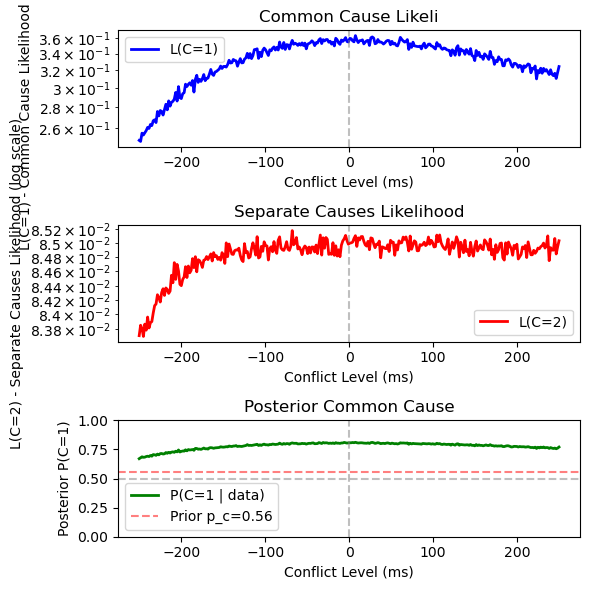

In [11]:
# Diagnostic: Compare L_C1 and L_C2 at extreme conflicts
def plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5,t_min=0.1,t_max=3, measurement="log-space", nSimul=2000):
    """
    Plot L_C1, L_C2, and their ratio across conflict levels to understand asymmetry.
    """
    conflicts = np.linspace(-0.25, +0.25, 300)
    L1_means = []
    L2_means = []
    post_c_means=[]
    ratio_means = []
    
    S_a_s = 0.5
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict
        
        # Skip invalid durations
        if measurement == "log-space" and S_v_s <= 0:
            L1_means.append(np.nan)
            L2_means.append(np.nan)
            ratio_means.append(np.nan)
            continue
        
        # Generate measurements
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate likelihoods
        L1 = L_C1(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        #L1= L_C1_no_prior(m_a_s, m_v_s, sigma_a, sigma_v)
        L2 = L_C2(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        #L2= L_C2_no_prior(m_a_s, m_v_s, sigma_a, sigma_v)
        L1_means.append(np.mean(L1))
        L2_means.append(np.mean(L2))
        
        post_c1= posterior_C1(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min_use, t_max_use)
        post_c_means.append(np.mean(post_c1))

        # Calculate ratio (avoid division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = L1 / (L1 + L2)
            #ratio=ratio * p_c / (ratio * p_c + (1 - p_c))
            ratio_means.append(np.mean(ratio))
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(6, 6))
    
    # Plot 1: L_C1 (Common cause likelihood)
    axes[0].semilogy(np.array(conflicts) * 1000, L1_means, 'b-', linewidth=2, label='L(C=1)')
    axes[0].set_xlabel('Conflict Level (ms)')
    axes[0].set_ylabel('L(C=1) - Common Cause Likelihood (log scale)')
    axes[0].set_title('Common Cause Likeli')
    #axes[0].grid(True, alpha=0.3)
    axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0].legend()
    
    # Plot 2: L_C2 (Separate causes likelihood)
    axes[1].semilogy(np.array(conflicts) * 1000, L2_means, 'r-', linewidth=2, label='L(C=2)')
    axes[1].set_xlabel('Conflict Level (ms)')
    axes[1].set_ylabel('L(C=2) - Separate Causes Likelihood (log scale)')
    axes[1].set_title('Separate Causes Likelihood')
    #axes[1].grid(True, alpha=0.3)
    axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].legend()
    
    # Plot 3: Posterior P(C=1) = L1*p_c / (L1*p_c + L2*(1-p_c))
    axes[2].plot(np.array(conflicts) * 1000, post_c_means, 'g-', linewidth=2, label='P(C=1 | data)')
    axes[2].set_xlabel('Conflict Level (ms)')
    axes[2].set_ylabel('Posterior P(C=1)')
    axes[2].set_title('Posterior Common Cause')
    #axes[2].grid(True, alpha=0.3)
    axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[2].axhline(round(p_c, 3), color='red', linestyle='--', alpha=0.5, label=f'Prior p_c={round(p_c, 3)}')
    axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_ylim([0, 1])
    axes[2].legend()
    
    plt.tight_layout()
    #plt.show()
    
    # Print key values
    zero_idx = np.argmin(np.abs(conflicts))
    neg_extreme_idx = 0
    pos_extreme_idx = -1
    
    print("\n=== Likelihood Analysis ===")
    print(f"At conflict=0ms:")
    print(f"  L(C=1) = {L1_means[zero_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[zero_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[zero_idx]:.3f}")
    
    print(f"\nAt conflict={conflicts[neg_extreme_idx]*1000:.0f}ms (extreme negative):")
    print(f"  L(C=1) = {L1_means[neg_extreme_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[neg_extreme_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[neg_extreme_idx]:.3f}")
    
    print(f"\nAt conflict={conflicts[pos_extreme_idx]*1000:.0f}ms (extreme positive):")
    print(f"  L(C=1) = {L1_means[pos_extreme_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[pos_extreme_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[pos_extreme_idx]:.3f}")

# Run diagnostic
plot_likelihood_components(sigma_a=0.5, sigma_v=0.3, p_c=0.56, measurement="log-space")

In [12]:
participantIds

['all',
 'as',
 'dt',
 'hh',
 'ip',
 'ln1',
 'ln2',
 'mh',
 'ml',
 'mt',
 'oy',
 'qs',
 'sx']

In [13]:
def plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5, t_min=0.1, t_max=3, 
                              measurement="log-space", nSimul=2000, axes=None, show_plot=True):
    """
    Plot L_C1, L_C2, and their ratio across conflict levels.
    If axes is provided, plot on those axes instead of creating new figure.
    """
    conflicts = np.linspace(-0.25, +0.25, 300)
    L1_means = []
    L2_means = []
    post_c_means = []
    ratio_means = []
    
    S_a_s = 0.5
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict
        
        if measurement == "log-space" and S_v_s <= 0:
            L1_means.append(np.nan)
            L2_means.append(np.nan)
            ratio_means.append(np.nan)
            continue
        
        # Generate measurements
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate likelihoods
        L1 = L_C1(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L2 = L_C2(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L1_means.append(np.mean(L1))
        L2_means.append(np.mean(L2))
        
        post_c1 = posterior_C1(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min_use, t_max_use)
        post_c_means.append(np.mean(post_c1))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = L1 / (L1 + L2)
            ratio_means.append(np.mean(ratio))
    
    # Use provided axes or create new figure
    if axes is None and show_plot:
        fig, axes = plt.subplots(3, 1, figsize=(9, 6))
        created_fig = True
    else:
        created_fig = False
    
    if show_plot:
        # Plot 1: L_C1 (Common cause likelihood)
        axes[0].semilogy(np.array(conflicts) * 1000, L1_means, 'b-', linewidth=2, label='L(C=1)')
        #axes[0].set_xlabel('Conflict (ms)')
        #axes[0].set_ylabel('L(C=1))')
        #axes[0].set_title('Common Cause Likelihood vs Conflict')
        axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
        #axes[0].legend()
        
        # Plot 2: L_C2 (Separate causes likelihood)
        axes[1].semilogy(np.array(conflicts) * 1000, L2_means, 'r-', linewidth=2, label='L(C=2)')
        axes[1].set_title ("L C=2")
        #axes[1].set_xlabel('Conflict (ms)')
        #axes[1].set_ylabel('L(C=2)')
        axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
        #axes[1].set_ylim()
        #axes[1].legend()
        
        # Plot 3: Posterior P(C=1)
        axes[2].plot(np.array(conflicts) * 1000, post_c_means, 'g-', linewidth=3, label='P(C=1 | data)')
        axes[2].set_xlabel('Conflict Level (ms)')
        #axes[2].set_ylabel('Posterior P(C=1)')
        axes[2].set_title('Posterior P(C=1)')
        axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
        axes[2].axhline(round(p_c, 3), color='red', linestyle='--', alpha=0.5, label=f'Prior p_c={round(p_c, 3)}')
        axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
        axes[2].set_ylim([0, 1])

        #axes[2].legend()
        axes[2].legend(
            [f"P(C=1 | data)", f"$\sigma_a={sigma_a:.2f},\sigma_v={sigma_v:.2f}$, \nPrior p_c={round(p_c, 3)}"],
            loc='lower right'
        )

        
        if created_fig:
            plt.tight_layout()
    
    return conflicts, L1_means, L2_means, post_c_means

def plotPosteriorsPerSubj(participantIds, modelTypes, parameterToPLot="mu"):
    lenSubjs = len(participantIds)
    fig, axes = plt.subplots(lenSubjs, 6, figsize=(20, 8*lenSubjs))  # 6 columns: 2 noise levels × 3 plots each
    
    for pNum, participantID in enumerate(participantIds):
        for modelType in ["lognorm"]:
            modelType = modelType.split("_")[0]
            
            # Load data and fit results
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            t_min_data = mc_fitter.data_t_min
            t_max_data = mc_fitter.data_t_max
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
            mc_fitter.modelFit = res['fittedParams']
            
            sigma_a = mc_fitter.modelFit[1]
            sigma_v = mc_fitter.modelFit[2]
            p_c = mc_fitter.modelFit[3]
            
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                if audioNoiseLevel == 0.1:
                    sigma_a = mc_fitter.modelFit[1]
                elif audioNoiseLevel == 1.2:
                    sigma_a = mc_fitter.modelFit[4]
                # Create axes for this noise level (3 subplots)
                start_col = j * 3
                if lenSubjs == 1:
                    subplot_axes = [axes[start_col], axes[start_col+1], axes[start_col+2]]
                else:
                    subplot_axes = [axes[pNum, start_col], axes[pNum, start_col+1], axes[pNum, start_col+2]]
                
                # Call plotting function with specific axes
                plot_likelihood_components(
                    sigma_a=sigma_a, 
                    sigma_v=sigma_v, 
                    p_c=p_c, 
                    t_min=t_min_data, 
                    t_max=t_max_data, 
                    measurement="log-space",
                    axes=subplot_axes,
                    show_plot=True
                )
                # Adjust the layout before adding the rectangle
                plt.tight_layout()

                # # Add a frame around the set of subplots for each noise level
                # rect = plt.Rectangle(
                #     (subplot_axes[0].get_position().x0 - 0.02, subplot_axes[0].get_position().y0 - 0.02),
                #     subplot_axes[2].get_position().x1 - subplot_axes[0].get_position().x0+0.03,
                #     subplot_axes[0].get_position().y1 - subplot_axes[0].get_position().y0 + 0.02,
                #     transform=fig.transFigure,
                #     color='black', fill=False, linewidth=2
                # )
                # fig.patches.append(rect)
                # Add noise level info to the first subplot
                subplot_axes[0].set_title(f"P: {participantID}, Noise: {audioNoiseLevel}\n" + subplot_axes[0].get_title())
    #plt.tight_layout()
    plt.show()

#plotPosteriorsPerSubj(participantIds, modelTypes, parameterToPLot="mu")

In [14]:
# Plot posterior per participants
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotPosteriorsPerSubj(participantIds, modelTypes, parameterToPLot="mu"):

    lenSubjs=len(participantIds)
    lenModels=len(modelTypes)
    plt.figure(figsize=(8,6*lenSubjs))
    for pNum,participantID in enumerate(participantIds):
        
        for modelType in ["lognorm"]:#modelTypes:
            modelType=modelType.split("_")[0]

            # 4 - read monte carlo fit results
            # 4.1 read data
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            t_min_data=mc_fitter.data_t_min
            t_max_data=mc_fitter.data_t_max
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
            print(f"Loaded saved fit results: {res}")
            mc_fitter.modelFit= res['fittedParams']
            mc_fitter.logLikelihood= res['logLikelihood']
            mc_fitter.aic= res['AIC']
            mc_fitter.bic= res['BIC']
            mc_fitter.nDataPoints= res['n_conditions']

            # plt.text(-1,0.4,f" Subj: {participantID},  Model: {modelType}")
            # for i in range(len(mc_fitter.modelFit)):
            #     plt.text(-1,0.35-(i*0.05),f" Param {i}: {mc_fitter.modelFit[i]:.4f}")
            # proceed to plot all fits together
            
            sigma_a= mc_fitter.modelFit[1]
            sigma_v= mc_fitter.modelFit[2]
            p_c= mc_fitter.modelFit[3]
            sigma_a2= mc_fitter.modelFit[4]
            lambda_2= mc_fitter.modelFit[5]
            lambda_3= mc_fitter.modelFit[6]
            #plt.subplot(lenSubjs,2 ,(pNum+1))
            #plt.title(f"Participant: {participantID}")
            print(50*"-")
            print(f"Participant: {participantID}, sigma_a: {sigma_a}, sigma_v: {sigma_v}, p_c: {p_c}, sigma_a2: {sigma_a2}, lambda_2: {lambda_2}, lambda_3: {lambda_3}")
            print(50*"-")
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                plot_likelihood_components(sigma_a=sigma_a, sigma_v=sigma_v, p_c=p_c, t_min=t_min_data, t_max=t_max_data, measurement="log-space")
            

            


#plotPosteriorsPerSubj(participantIds[:4], modelTypes, parameterToPLot="mu")              

# Unimodal psychometric fits and predicted fits

In [15]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

Loaded real data psychometric fit for all from psychometric_fits_real/all/all_psychometricFits.json
Loaded simulated data psychometric fit for all, model lognorm from psychometric_fits_simulated/all/all_lognorm_psychometricFits.json✅
Loaded saved fit results: {'participantID': 'all', 'modelType': 'lognorm_LapseFree_sharedPrior', 'fittedParams': [0.1148295617881552, 0.26510078233769274, 0.5252749505013505, 0.9944184451434158, 0.568894575886471, 0.09512338326531265, 0.17045617522356135], 'AIC': 25336.161906657137, 'BIC': 25382.38164859882, 'logLikelihood': -12661.080953328568, 'n_conditions': 5447}
[0.14607833747544183, 0.11484320405899716, 0.18444107147422567, 0.2710020612427595, 0.1584561025903902, -0.1588964378898503, -0.10944863779822307, -0.0021506924085651848, 0.041315050353740494, 0.10103447200513085, 0.1074849977308987, 0.13090042805641935, -0.04271356024717934, -0.01808469178065553, 0.013017813258570796, 0.011945128690030539, 0.013064989774131772, 0.03533842571051217, 0.04665169

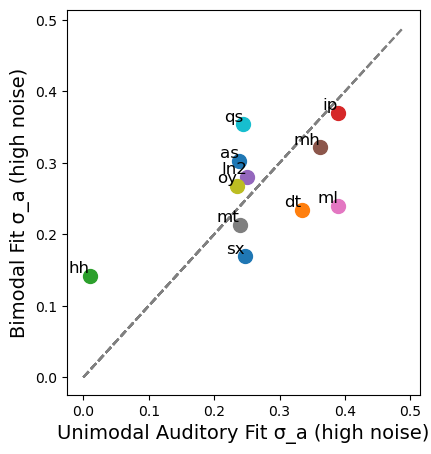

In [16]:
import scipy.io
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# unimodal psychometric fits and predicted fits
for pNum,participantID in enumerate(participantIds):
    # import forced fusion model simulation fit
    for modelType in ["lognorm"]:#modelTypes:
        modelType=modelType.split("_")[0]
        # 1- read psychometric fits for real data
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
                print(f"Loaded real data psychometric fit for {participantID} from {real_fit_path}")
        except Exception as e:
            print(f"Error loading real data psychometric fit for {participantID}: {e}")
            continue

        #print(f"Real fit params: {real_fit['fitParams']}\n\n\n")


        # 2- read psychometric fits for simulated data
        sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType}_psychometricFits.json")
        try:
            with open(sim_fit_path, 'r') as f:
                sim_fit = json.load(f)
            print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType} from {sim_fit_path}✅")
#            print(f"Simulated fit params: {sim_fit['fitParams']}")
        except Exception as e:
            print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType}: {e}\n❗")
            continue
        


        # 4 - read monte carlo fit results
        # 4.1 read data
        data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
        print(f"Loaded saved fit results: {res}")
        mc_fitter.modelFit= res['fittedParams']
        mc_fitter.logLikelihood= res['logLikelihood']
        mc_fitter.aic= res['AIC']
        mc_fitter.bic= res['BIC']
        mc_fitter.nDataPoints= res['n_conditions']

        print(real_fit["fitParams"])
        sigma_a_real_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]
        print(f"\n\n\nsigma_a_real_high: {sigma_a_real_high}\n\n\n")
        sigma_a_real_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]


        #print(f"\n\nParticipant: {participantID}, MC fitted sigma_a high noise: {sigma_a_real_high}\n\n\n")


        # 5- Read unimodal fits
        # unimodal auditory fits
        # join /data/ to path
        # load matlab file
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            print(50*"-")
            #print(f"Participant: {participantID}, Auditory fit params: {auditory_fit_params}")
            #print(f"sigma_a_high: {auditory_fit_params[1]}, sigma_a_low: {auditory_fit_params[2]}")
            #print(f"Loaded auditory fit params for {participantID} from {auditory_fit_path}: {auditory_fit_params}")
        except Exception as e:
            print(f"Error loading auditory fit params for {participantID} from {auditory_fit_path}: {e}\n❗")
            continue


        # visual unimodal fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            #print(f"Participant: {participantID}, Visual fit params: {visual_fit_params}")
            #print(f"sigma_v: {visual_fit_params[1]}")
            #print(f"Loaded visual fit params for {participantID} from {visual_fit_path}: {visual_fit_params}")
        except Exception as e:
            print(f"Error loading visual fit params for {participantID} from {visual_fit_path}: {e}\n❗")
            continue

        # 6 - Compare unimodal sigmas to MC fit sigmas
        sigma_a_mc_low = mc_fitter.modelFit[1]
        sigma_a_mc_high = mc_fitter.modelFit[4]
        sigma_v_mc = mc_fitter.modelFit[4]
        print(50*"-")
        print(f"Participant: {participantID}")
        
        # scatter plot auditory high to MC fit high noise auditory sigma
        #
        plt.scatter(auditory_fit_params[2], sigma_a_real_high, label=f"{participantID}", s=100)
        #as text draw the participantID next to the point
        plt.text(auditory_fit_params[2], sigma_a_real_high, participantID, fontsize=12, ha='right', va='bottom')
        plt.xlabel("Unimodal Auditory Fit σ_a (high noise)", fontsize=14)
        plt.ylabel("Bimodal Fit σ_a (high noise)", fontsize=14)
        # draw unity line
        plt.plot([0, max(auditory_fit_params[2], sigma_a_real_high)+0.1], [0, max(auditory_fit_params[2], sigma_a_real_high)+0.1], color='gray', linestyle='--')
        #plt.plot([0, max(auditory_fit_params[2], sigma_a_mc_high)+0.1], [0, max(auditory_fit_params[2], sigma_a_mc _high)+0.1], color='gray', linestyle='--')
        



            


In [17]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


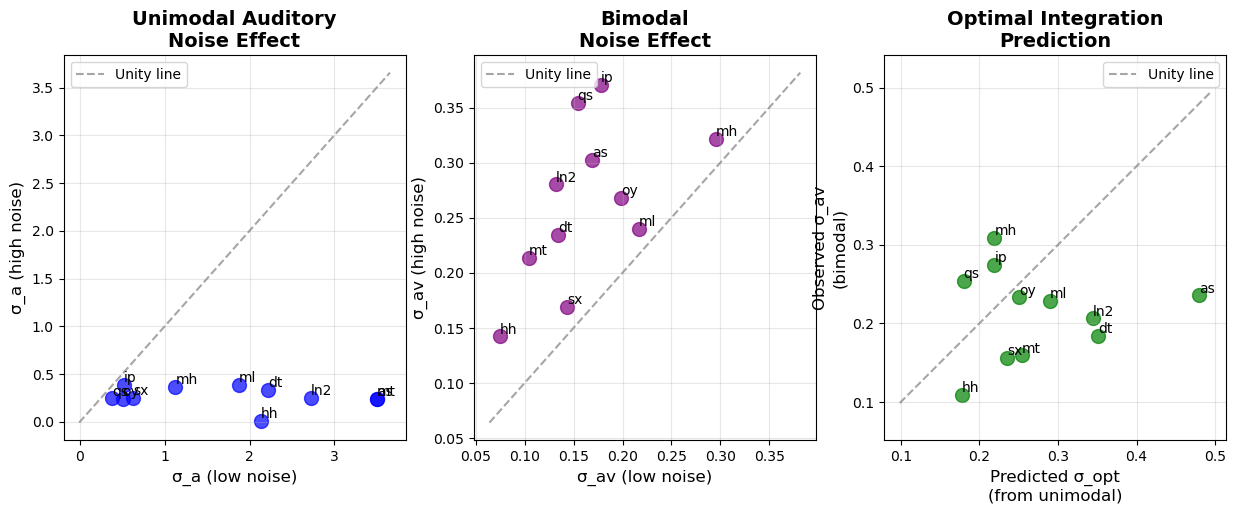

Text(0.5, 1.02, 'Noise Effects and Optimal Integration Analysis')

<Figure size 640x480 with 0 Axes>

In [18]:
import scipy.io
plt.figure(figsize=(15, 5))

# More meaningful sigma comparison: 
# 1. Auditory noise effect (unimodal high vs low)
# 2. Bimodal noise effect (sigma_av high vs low)
# 3. Predicted optimal integration vs observed bimodal sigma_av

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av) for high and low noise conditions
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  # Combined sigma_av at high noise
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   # Combined sigma_av at low noise

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  # High noise
            sigma_a_low = auditory_fit_params[1]   # Low noise
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        # sigma_opt = 1/sqrt(1/sigma_a_sensory^2 + 1/sigma_v_sensory^2)
        sigma_opt_high = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)

        # Plot 1: Auditory noise effect (high vs low) - Unimodal
        plt.subplot(1, 3, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=10, ha='left', va='bottom')
        
        # Plot 2: Auditory noise effect in Bimodal (high vs low)
        plt.subplot(1, 3, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=10, ha='left', va='bottom')
        
        # Plot 3: Predicted optimal vs observed (average across both conditions)
        sigma_opt_avg = (sigma_opt_high + sigma_opt_low) / 2
        sigma_av_avg = (sigma_av_high + sigma_av_low) / 2
        plt.subplot(1, 3, 3)
        plt.scatter(sigma_opt_avg, sigma_av_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_avg, sigma_av_avg, participantID,
                fontsize=10, ha='left', va='bottom')

# Format plots
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low noise)", "σ_a (high noise)"),
    ("Bimodal\nNoise Effect", "σ_av (low noise)", "σ_av (high noise)"), 
    ("Optimal Integration\nPrediction", "Predicted σ_opt\n(from unimodal)", "Observed σ_av\n(bimodal)")
], 1):
    
    plt.subplot(1, 3, i)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add unity line
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity line')
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Make axes equal for better comparison


plt.axis('equal')
plt.show()
    

plt.tight_layout()
plt.suptitle('Noise Effects and Optimal Integration Analysis', fontsize=13, y=1.02)

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


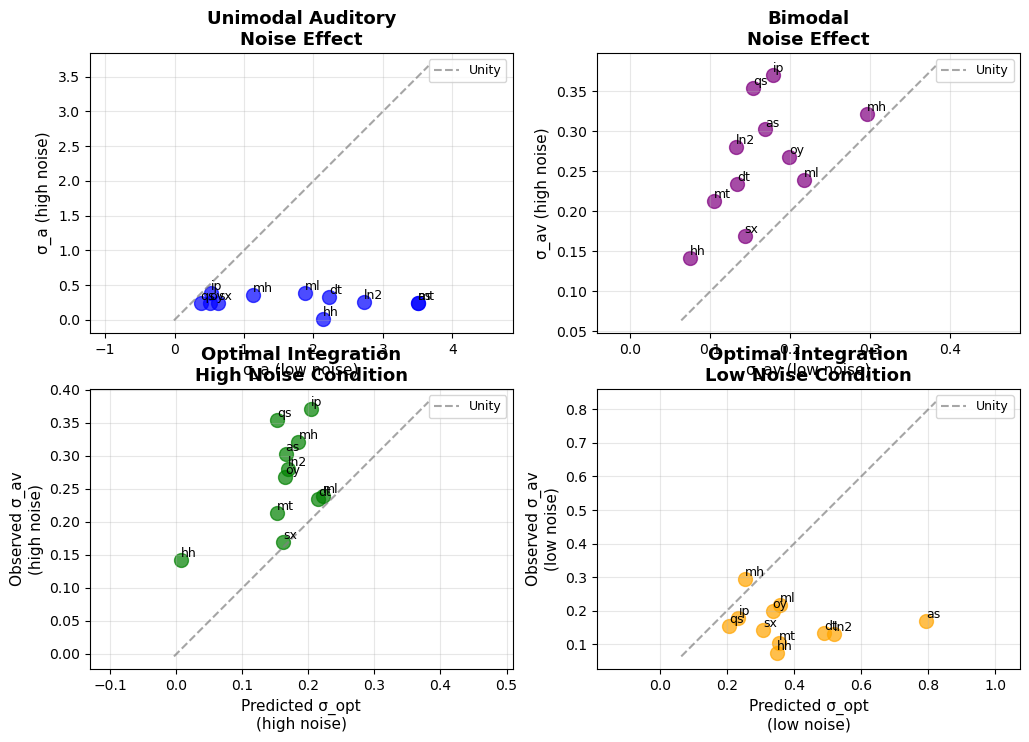

Text(0.5, 1.0, 'Noise Effects and Optimal Integration by Condition')

<Figure size 640x480 with 0 Axes>

In [19]:
import scipy.io
plt.figure(figsize=(12, 8))  # 2x2 layout

# Comprehensive noise and integration analysis

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av)
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   

        # Extract model-fitted sigmas
        sigma_av_model_high = mc_fitter.getParamsCausal(mc_fitter.modelFit, 1.2, 0)[1]
        sigma_av_model_low = mc_fitter.getParamsCausal(mc_fitter.modelFit, 0.1, 0)[1]

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  
            sigma_a_low = auditory_fit_params[1]   
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        sigma_opt_high = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)

        # Plot 1: Unimodal auditory noise effect
        plt.subplot(2, 2, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=9, ha='left', va='bottom')
        
        # Plot 2: Bimodal noise effect
        plt.subplot(2, 2, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 3: Optimal prediction vs observed (high noise)
        plt.subplot(2, 2, 3)
        plt.scatter(sigma_opt_high, sigma_av_high, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_high, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 4: Optimal prediction vs observed (low noise)
        plt.subplot(2, 2, 4)
        plt.scatter(sigma_opt_low, sigma_av_low, s=100, alpha=0.7, color='orange')
        plt.text(sigma_opt_low, sigma_av_low, participantID,
                fontsize=9, ha='left', va='bottom')

# Format plots
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low noise)", "σ_a (high noise)"),
    ("Bimodal\nNoise Effect", "σ_av (low noise)", "σ_av (high noise)"), 
    ("Optimal Integration\nHigh Noise Condition", "Predicted σ_opt\n(high noise)", "Observed σ_av\n(high noise)"),
    ("Optimal Integration\nLow Noise Condition", "Predicted σ_opt\n(low noise)", "Observed σ_av\n(low noise)")
], 1):
    
    plt.subplot(2, 2, i)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    
    # Add unity line
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

plt.show()

plt.tight_layout()            
plt.suptitle('Noise Effects and Optimal Integration by Condition',  fontsize=13, y=1.00)

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


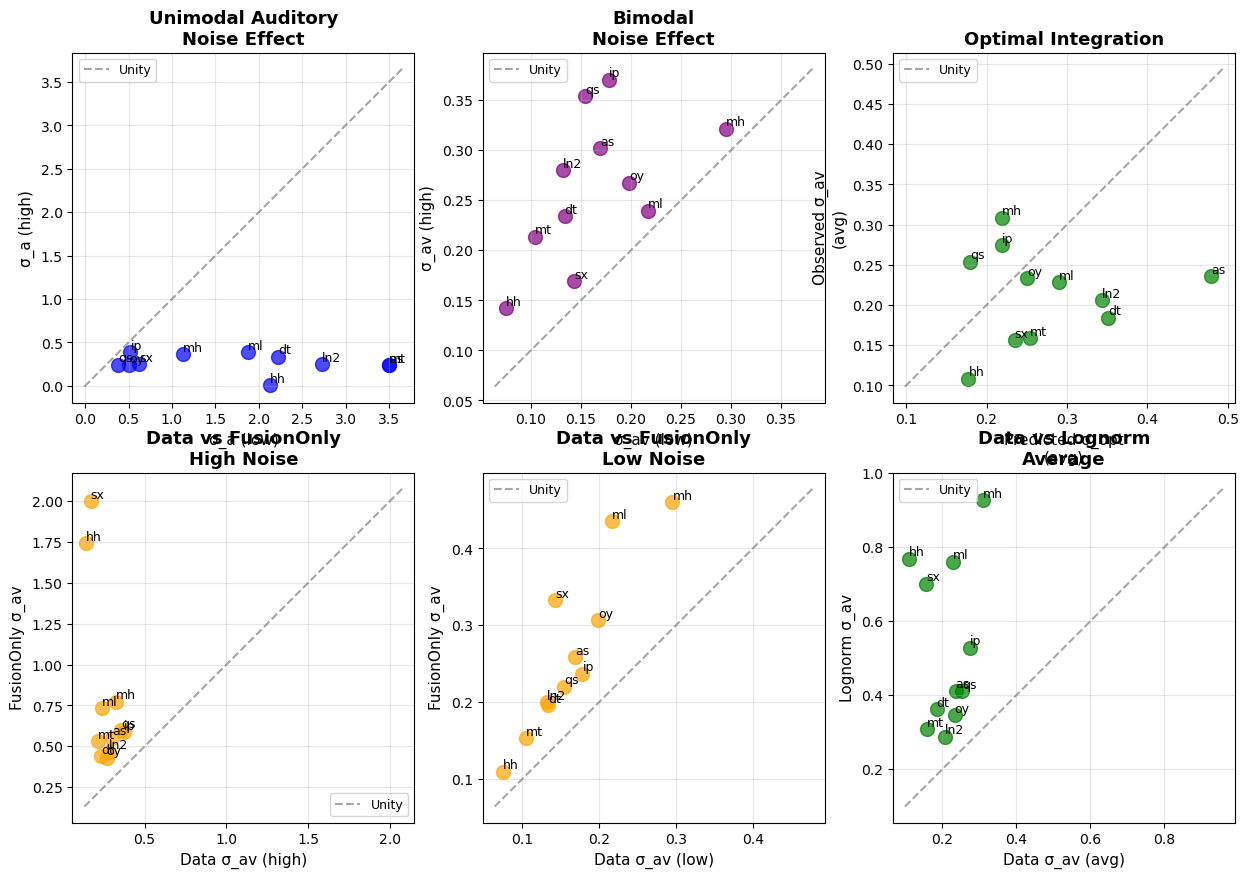

Text(0.5, 1.0, 'Comprehensive Sigma Analysis: Noise Effects, Optimal Integration & Model Fits')

<Figure size 640x480 with 0 Axes>

In [20]:
import scipy.io
plt.figure(figsize=(15, 10))  # 2 rows x 3 columns

# Comprehensive analysis: Noise effects, Optimal integration, and Model comparisons

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av)
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   

        # Extract FusionOnly model-fitted sigmas
        sigma_av_model_high = mc_fitter.getParamsCausal(mc_fitter.modelFit, 1.2, 0)[1]
        sigma_av_model_low = mc_fitter.getParamsCausal(mc_fitter.modelFit, 0.1, 0)[1]

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  
            sigma_a_low = auditory_fit_params[1]   
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # 5- Load lognorm model results
        mc_fitter_lognorm = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter_lognorm.modelName = "lognorm"
        mc_fitter_lognorm.freeP_c = False
        mc_fitter_lognorm.sharedLambda = False
        mc_fitter_lognorm.dataName = dataName 
        res_lognorm = loadResults.loadFitResults(mc_fitter_lognorm, dataName, modelName=mc_fitter_lognorm.modelName)
        mc_fitter_lognorm.modelFit = res_lognorm['fittedParams']
        
        # Extract lognorm model sigmas
        sigma_av_lognorm_high = mc_fitter_lognorm.getParamsCausal(mc_fitter_lognorm.modelFit, 1.2, 0)[1]
        sigma_av_lognorm_low = mc_fitter_lognorm.getParamsCausal(mc_fitter_lognorm.modelFit, 0.1, 0)[1]

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        sigma_opt_high = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)

        # FIRST ROW: Basic comparisons
        # Plot 1: Unimodal auditory noise effect
        plt.subplot(2, 3, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=9, ha='left', va='bottom')
        
        # Plot 2: Bimodal noise effect
        plt.subplot(2, 3, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 3: Optimal prediction vs observed (averaged)
        sigma_opt_avg = (sigma_opt_high + sigma_opt_low) / 2
        sigma_av_avg = (sigma_av_high + sigma_av_low) / 2
        plt.subplot(2, 3, 3)
        plt.scatter(sigma_opt_avg, sigma_av_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_avg, sigma_av_avg, participantID,
                fontsize=9, ha='left', va='bottom')

        # SECOND ROW: Model comparisons
        # Plot 4: Data vs FusionOnly (high noise)
        plt.subplot(2, 3, 4)
        plt.scatter(sigma_av_high, sigma_av_model_high, s=100, alpha=0.7, color='orange')
        plt.text(sigma_av_high, sigma_av_model_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 5: Data vs FusionOnly (low noise)
        plt.subplot(2, 3, 5)
        plt.scatter(sigma_av_low, sigma_av_model_low, s=100, alpha=0.7, color='orange')
        plt.text(sigma_av_low, sigma_av_model_low, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 6: Data vs Lognorm (averaged)
        sigma_av_lognorm_avg = (sigma_av_lognorm_high + sigma_av_lognorm_low) / 2
        plt.subplot(2, 3, 6)
        plt.scatter(sigma_av_avg, sigma_av_lognorm_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_av_avg, sigma_av_lognorm_avg, participantID,
                fontsize=9, ha='left', va='bottom')

# Format plots
# First row
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low)", "σ_a (high)"),
    ("Bimodal\nNoise Effect", "σ_av (low)", "σ_av (high)"), 
    ("Optimal Integration", "Predicted σ_opt\n(avg)", "Observed σ_av\n(avg)")
], 1):
    
    plt.subplot(2, 3, i)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

# Second row
for i, (title, xlabel, ylabel) in enumerate([
    ("Data vs FusionOnly\nHigh Noise", "Data σ_av (high)", "FusionOnly σ_av"),
    ("Data vs FusionOnly\nLow Noise", "Data σ_av (low)", "FusionOnly σ_av"), 
    ("Data vs Lognorm\nAverage", "Data σ_av (avg)", "Lognorm σ_av")
], 4):
    
    plt.subplot(2, 3, i)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

plt.show()

plt.tight_layout()            
plt.suptitle('Comprehensive Sigma Analysis: Noise Effects, Optimal Integration & Model Fits',  fontsize=13, y=1.00)

In [21]:
# Interactive plotting with model selection
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

def create_interactive_plot(selected_models,biasCorrection, verbose=False):
    """Create plots for selected models"""
    if not selected_models:
        print("Please select at least one model to display")
        return
    
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
        
    with plot_output:
        clear_output(wait=True)
        
        lenSubjs = len(participantIds)
        fig, axes = plt.subplots(lenSubjs, 2, figsize=(12, 6*lenSubjs))
        if lenSubjs == 1:
            axes = axes.reshape(1, -1)
        
        for pNum, participantID in enumerate(participantIds):
            for modelType in selected_models:
                modelType_clean = modelType.split("_")[0]
                
                # 1- read psychometric fits for real data
                real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
                try:
                    with open(real_fit_path, 'r') as f:
                        real_fit = json.load(f)
                    _print(f"Loaded real data psychometric fit for {participantID}")
                except Exception as e:
                    _print(f"Error loading real data psychometric fit for {participantID}: {e}")
                    continue

                # 2- read psychometric fits for simulated data
                sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType_clean}_psychometricFits.json")
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                    _print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType_clean}✅")
                except Exception as e:
                    _print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType_clean}: {e}")
                    continue
                
                # 3 - Read the bootstrapped fits for real data
                bootPath = participantID + "_dataFit_bootstrapped_params.json"
                dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
                try:
                    with open(dataBootsPath, 'r') as f:
                        content = f.read().strip()
                        dataBoots = json.loads(content) if content else {}
                    _print(f"Loaded bootstrapped params for {participantID}")
                except Exception as e:
                    _print(f"Error loading bootstrapped params for {participantID}: {e}")
                    continue

                # 4 - read monte carlo fit results
                data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
                mc_fitter = monteCarloClass.OmerMonteCarlo(data)
                mc_fitter.modelName = modelType_clean
                mc_fitter.freeP_c = False
                mc_fitter.sharedLambda = False
                mc_fitter.dataName = dataName 
                res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
                _print(f"Loaded saved fit results for {participantID}")
                mc_fitter.modelFit = res['fittedParams']
                mc_fitter.logLikelihood = res['logLikelihood']
                mc_fitter.aic = res['AIC']
                mc_fitter.bic = res['BIC']
                mc_fitter.nDataPoints = res['n_conditions']

                # Get model color (consistent color for each model)
                model_colors = {
                    'fusionOnlyLogNorm_sharedPrior': 'red',
                    'logLinearMismatch_sharedPrior': 'blue',
                    'lognorm_sharedPrior': 'green',
                    'probabilityMatchingLogNorm_sharedPrior': 'orange',
                    'selection_sharedPrior': 'purple',
                    'switchingFree_sharedPrior': 'brown'
                }
                model_color = model_colors.get(modelType, 'black')  # Default to black if modelType is not in the dictionary
                
                # proceed to plot all fits together
                for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                    conflict_levels = []
                    mu_models = []

                    # Calculate baseline PSE at conflict == 0
                    baseline_pse = np.mean([mc_fitter.getParams(boot, 0, audioNoiseLevel)[1] for boot in dataBoots])
                    #print(f"Baseline PSE for participant {participantID}, audio noise {audioNoiseLevel}: {baseline_pse}")

                    
                    for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        conflict_levels.append(conflictLevel)
                        
                        # Select the correct subplot
                        if lenSubjs == 1:
                            ax = axes[j]
                        else:
                            ax = axes[pNum, j]
                        
                        plt.sca(ax)
                        
                        if modelType == selected_models[0]:  # Only set title and plot data for first model
                            ax.set_title(f"Participant: {participantID}, Audio Noise: {audioNoiseLevel}")
                            
                            # Plot bootstrap data (only once)
                            bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                            if biasCorrection:
                                bootMus = np.array(bootMus) - baseline_pse  # Center around baseline
                            if audioNoiseLevel == 0.1:
                                color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                            elif audioNoiseLevel == 1.2:
                                color = sns.color_palette("Blues", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                            
                            ax.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), 
                                      color="black", fmt='o', capsize=5, alpha=1, label='Data' if k == 0 else "")

                        # Plot model predictions
                        paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)
                        muModel = paramsSimDf[1]
                        
                        # 
                        #print(f"Model {modelType}, fitted parameters are: {sim_fit['fitParams']}")

                        baseline_mu_model = mc_fitter.getParams(sim_fit['fitParams'], 0, audioNoiseLevel)[1]
                        if biasCorrection:
                            muModel -= baseline_mu_model  # Center around model baseline
                        #muModel -= baseline_pse  # Center around baseline
                        mu_models.append(muModel)

                        #max(mu_models)

                        ax.plot(conflictLevel, muModel, color=model_color, alpha=1, linestyle='--', 
                               marker='o', markersize=6, label=f'{modelType}' if k == 0 else "")
                        
                        # Set common plot properties (only for first model to avoid repetition)
                        if modelType == selected_models[0]:
                            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                            ax.set_ylim(-0.35, 0.35)
                            ax.tick_params(axis='both', labelsize=12)
                            if pNum == lenSubjs - 1:  # Only add xlabel to bottom plots
                                ax.set_xlabel("Conflict (ms)", fontsize=14)
                            if j == 0:  # Only add ylabel to left plots
                                ax.set_ylabel("PSE shift (ms)", fontsize=14)

                    # Convert lists to arrays and sort them for a proper line plot
                    conflict_levels = np.array(conflict_levels)
                    mu_models = np.array(mu_models)
                    sorted_indices = np.argsort(conflict_levels)
                    conflict_levels_sorted = conflict_levels[sorted_indices]
                    mu_models_sorted = mu_models[sorted_indices]
                    
                    # Select the correct subplot for continuous line
                    if lenSubjs == 1:
                        ax = axes[j]
                    else:
                        ax = axes[pNum, j]
                    
                    ax.plot(conflict_levels_sorted, mu_models_sorted, color=model_color, alpha=0.7, linestyle='-', linewidth=3)
        
        # Add legend to the first subplot
        if lenSubjs == 1:
            axes[0].legend(loc='upper right', fontsize=10)
        else:
            axes[0, 0].legend(loc='upper right', fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Create model selection checkboxes
model_checkboxes = []
for model in modelTypes:
    checkbox = widgets.Checkbox(
        value=(model == "lognorm_sharedPrior"),  # Default to first model selected
        description=model,
        disabled=False,
        layout=widgets.Layout(width='200px')
    )
    model_checkboxes.append(checkbox)

# Create update button
update_button = widgets.Button(
    description='Update Plot',
    disabled=False,
    button_style='success',
    tooltip='Click to update the plot with selected models',
)

# Create output widget for the plot
plot_output = widgets.Output()

biasCorrection=0
def on_button_click(b):
    selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
    create_interactive_plot(selected_models, biasCorrection=biasCorrection)

update_button.on_click(on_button_click)

# Layout the widgets
checkbox_container = widgets.VBox(model_checkboxes)
control_panel = widgets.HBox([checkbox_container, widgets.VBox([update_button])])

print("Interactive Model Comparison Plot")
print("Select the models you want to compare and click 'Update Plot':")
display(control_panel)
display(plot_output)

# Initial plot with default selection
selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
create_interactive_plot(selected_models, biasCorrection=biasCorrection)

Interactive Model Comparison Plot
Select the models you want to compare and click 'Update Plot':


Output()